## 1. 选择一个数据

shape of moons (10000, 2)


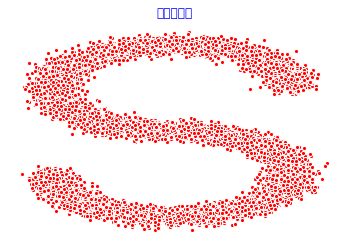

In [53]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_checkerboard,make_circles,make_moons,make_s_curve,make_swiss_roll
import torch

s_curve, _= make_s_curve(10**4, noise=0.1)
s_curve = s_curve[:, [0, 2]]/10.0

print("shape of moons", np.shape(s_curve))

moons, _ = make_moons(10**4, noise=0.1)

data = s_curve.T

fig,axe = plt.subplots()

axe.scatter(*data, color='red', edgecolor='white', s=17);
axe.axis('off')
axe.set_title("数据集展示", color='blue')

dataset = torch.Tensor(data.T).float()

## 2. 确定超参数的值

In [43]:
from sklearn.datasets import make_checkerboard,make_circles,make_moons,make_s_curve,make_swiss_roll

num_steps = 100

betas = torch.linspace(-6, 6, num_steps)
betas = torch.sigmoid(betas) * (0.5e-2 - 1e-5) + 1e-5
# print("betas : ", betas)   # 制定每一步的beta

alphas = 1 - betas
alphas_prod = torch.cumprod(alphas, 0)  # 连乘
alphas_prod_p = torch.cat([torch.tensor([1]).float(), alphas_prod[:-1]], 0)  # previous连乘
alphas_bar_sqrt = torch.sqrt(alphas_prod)  # 开根号
one_minus_alphas_bar_log = torch.log(1 - alphas_prod)
one_minus_alphas_bar_sqrt = torch.sqrt(1 - alphas_prod)

assert betas.shape==alphas.shape==alphas_prod.shape==alphas_bar_sqrt.shape==one_minus_alphas_bar_log.shape==one_minus_alphas_bar_sqrt.shape

print("all the same shape : ", betas.shape)

all the same shape :  torch.Size([100])


## 3. 确定扩散任意时刻的采样值

In [44]:
def q_x(x_0, t, noise=None):
    # 从 x[0] 到  x[t]
    
    if noise is None:
        noise = torch.randn_like(x_0)
    alphas_t = alphas_bar_sqrt[t]
    alphas_1_m_t = one_minus_alphas_bar_sqrt[t]
    return (alphas_t * x_0 + alphas_1_m_t * noise)

## 4. 演示原始数据加噪100步的效果

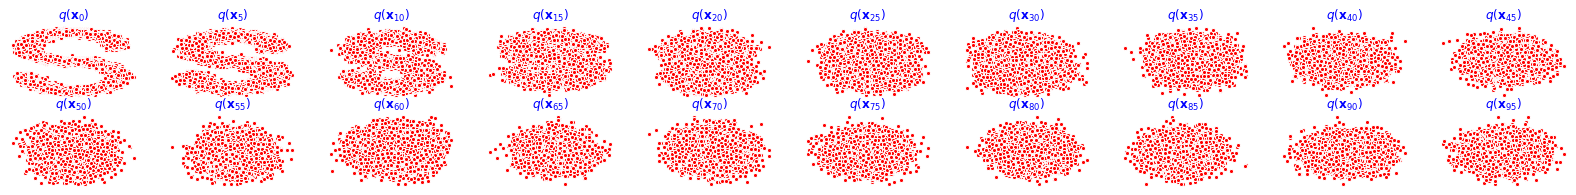

In [45]:
num_shows = 20
fig, axs = plt.subplots(2, 10, figsize=(28, 3))

for i in range(num_shows):
    j = i // 10  # 行
    k = i % 10   # 列
    q_i = q_x(dataset, torch.tensor([i * num_steps//num_shows]))
    axs[j,k].scatter(q_i[:, 0], q_i[:, 1],color='red',edgecolor='white', s=17);
    axs[j,k].set_axis_off(); 
    axs[j,k].set_title('$q(\mathbf{x}_{'+str(i * num_steps//num_shows)+'})$', color='blue')

## 5. 编写拟合逆扩散过程高斯分布模型

In [46]:
import torch.nn as nn
import torch.nn.functional as F

class MLPDiffusion(nn.Module):
    
    def __init__(self, n_steps, num_units=128):
        super(MLPDiffusion, self).__init__()
        
        self.linears = nn.ModuleList(
            [
                nn.Linear(2, num_units),
                nn.ReLU(),
                nn.Linear(num_units, num_units),
                nn.ReLU(),
                nn.Linear(num_units, num_units),
                nn.ReLU(),
                nn.Linear(num_units, 2),
            ]
        )
        
        self.step_embeddings = nn.ModuleList(
            [
                nn.Embedding(n_steps, num_units),
                nn.Embedding(n_steps, num_units),
                nn.Embedding(n_steps, num_units),
            ]
        )
            

    def forward(self, x_0, t):
        
        x = x_0
        for idx, embedding_layer in enumerate(self.step_embeddings):
            t_embedding = embedding_layer(t)
            x = self.linears[2*idx](x)  # 线性层
            x += t_embedding
            x = self.linears[2*idx+1](x) # relu层
        
        x = self.linears[-1](x)

        return x

# model = MLPDiffusion(n_steps=100)
# print(model)

## 6. 编写训练的误差函数

In [47]:
def diffusion_loss_fn(model, x_0,alphas_bar_sqrt, one_minus_alphas_bar_sqrt,n_steps):
    
    batch_size = x_0.shape[0]  # 数据点个数

    t = torch.randint(0, n_steps, size=(batch_size // 2,))  # [64, 1]
#     print("t1",t)
#     print("diffusion_loss_fn___t1", np.shape(t))
    t = torch.cat([t, n_steps - t - 1], dim=0)              # [128, 1]
#     print("t2",t)
#     print("diffusion_loss_fn___t2", np.shape(t))
    t = t.unsqueeze(-1)                                     # [1, 128]
#     print("t3",t)
#     print("diffusion_loss_fn___t3", np.shape(t))
    
    a = alphas_bar_sqrt[t]                                  # [128, 1]
    am1 = one_minus_alphas_bar_sqrt[t]                      # [128, 1]
    e = torch.randn_like(x_0)                               # [128, 1]
    
    x_t = x_0*a + am1*e                                     # [128, 1]
    output = model(x_t, t.squeeze(-1))  # 送入模型，得到t时刻随机噪声预测值
    
    outloss = (e - output).square().mean() # 预测噪声与真实噪声误差平方，求均值
    
    return outloss

## 7. 编写逆扩散采样函数

In [48]:
# 从 x[t] 到 x[t-1], x[t-2], ... , x[0]

def extract(input, t, x):
    shape = x.shape
    out = torch.gather(input, 0, t.to(input.device))
    reshape = [t.shape[0]] + [1] * (len(shape) - 1)
    return out.reshape(*reshape)
# torch.gather : 收集输入的特定维度指定位置的数值
# 参数：
# input(tensor): 待操作数。不妨设其维度为（x1, x2, …, xn）
# dim(int): 待操作的维度。
# index(LongTensor): 如何对input进行操作。
#                   其维度有限定，例如当dim=i时，index的维度为（x1, x2, …y, …,xn），
#                   既是将input的第i维的大小更改为y，且要满足y>=1（除了第i维之外的其他维度，大小要和input保持一致）。
# out: 注意输出和index的维度是一致的


def p_sample(model, x, t,alphas,betas,one_minus_alphas_bar_sqrt):
    t = torch.tensor([t])
    eps_factor = ((1 - extract(alphas, t, x)) / extract(one_minus_alphas_bar_sqrt, t, x))
    eps_theta = model(x, t)
    mean = (1 / extract(alphas, t, x).sqrt()) * (x - (eps_factor * eps_theta))
    z = torch.randn_like(x)
    sigma_t = extract(betas, t, x).sqrt()
    sample = mean + sigma_t * z
    return (sample)

def p_sample_loop(model, shape,n_steps,alphas,betas,one_minus_alphas_bar_sqrt):
    cur_x = torch.randn(shape)
    x_seq = [cur_x]
    for i in reversed(range(n_steps)): # reversed()函数的作用是返回一个反转的迭代器
        # i = 100,99,98,...,1,0
        cur_x = p_sample(model, cur_x, i,alphas,betas,one_minus_alphas_bar_sqrt)
        x_seq.append(cur_x)
    print("-------------------------")
    return x_seq

## 8.  开始训练模型，打印loss，打印中间重构效果

__________开始训练____________
epoch: 0      loss: tensor(0.5905, grad_fn=<MeanBackward0>)
-------------------------
epoch: 100      loss: tensor(0.5735, grad_fn=<MeanBackward0>)
-------------------------
epoch: 200      loss: tensor(0.6276, grad_fn=<MeanBackward0>)
-------------------------
epoch: 300      loss: tensor(0.3609, grad_fn=<MeanBackward0>)
-------------------------
epoch: 400      loss: tensor(0.5087, grad_fn=<MeanBackward0>)
-------------------------
epoch: 500      loss: tensor(0.4433, grad_fn=<MeanBackward0>)
-------------------------
epoch: 600      loss: tensor(0.4276, grad_fn=<MeanBackward0>)
-------------------------
epoch: 700      loss: tensor(0.5935, grad_fn=<MeanBackward0>)
-------------------------
epoch: 800      loss: tensor(0.4169, grad_fn=<MeanBackward0>)
-------------------------
epoch: 900      loss: tensor(0.2683, grad_fn=<MeanBackward0>)
-------------------------
epoch: 1000      loss: tensor(0.2348, grad_fn=<MeanBackward0>)
-------------------------
epoch:

/var/folders/zq/7_zhwc6n64x8gpntc779c9lh0000gn/T/ipykernel_6428/2803493711.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(1, 10, figsize=(28, 3))


epoch: 2100      loss: tensor(0.3821, grad_fn=<MeanBackward0>)
-------------------------
epoch: 2200      loss: tensor(0.7057, grad_fn=<MeanBackward0>)
-------------------------
epoch: 2300      loss: tensor(0.2896, grad_fn=<MeanBackward0>)
-------------------------
epoch: 2400      loss: tensor(0.4288, grad_fn=<MeanBackward0>)
-------------------------
epoch: 2500      loss: tensor(0.2916, grad_fn=<MeanBackward0>)
-------------------------
epoch: 2600      loss: tensor(0.3949, grad_fn=<MeanBackward0>)
-------------------------
epoch: 2700      loss: tensor(0.2765, grad_fn=<MeanBackward0>)
-------------------------
epoch: 2800      loss: tensor(0.1786, grad_fn=<MeanBackward0>)
-------------------------
epoch: 2900      loss: tensor(0.2870, grad_fn=<MeanBackward0>)
-------------------------
epoch: 3000      loss: tensor(0.5996, grad_fn=<MeanBackward0>)
-------------------------
epoch: 3100      loss: tensor(0.3048, grad_fn=<MeanBackward0>)
-------------------------
epoch: 3200      loss

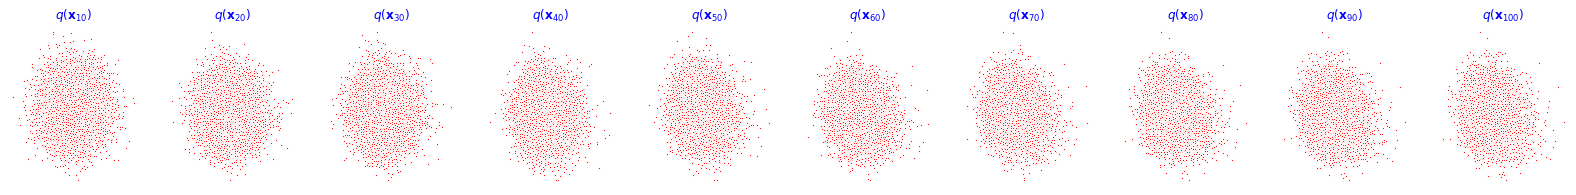

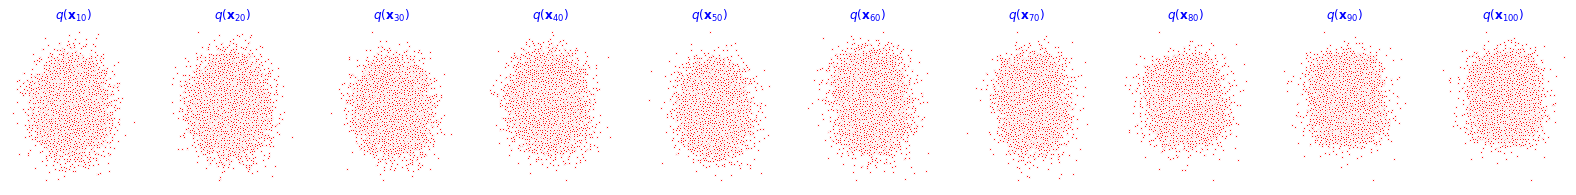

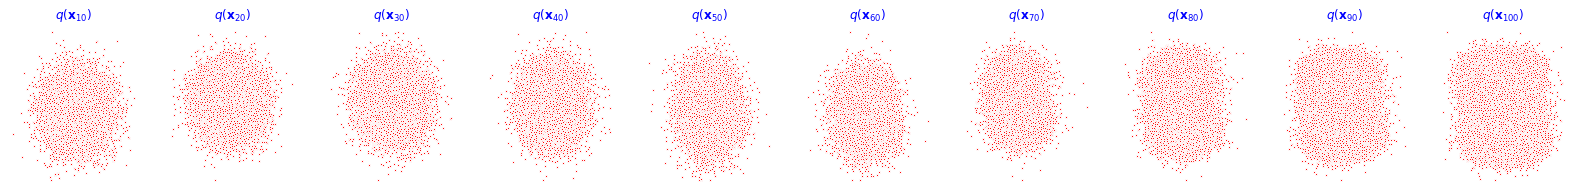

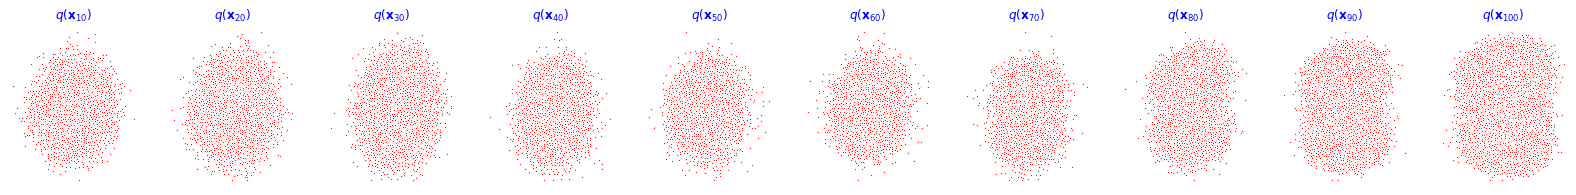

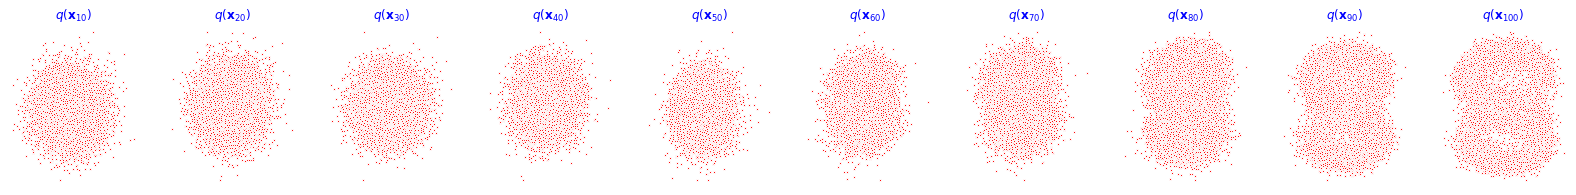

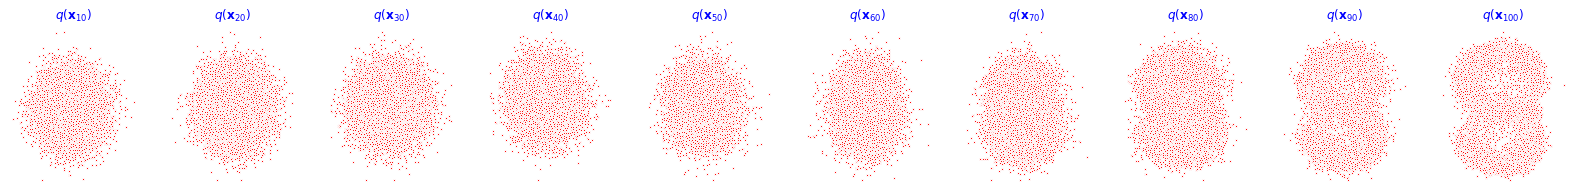

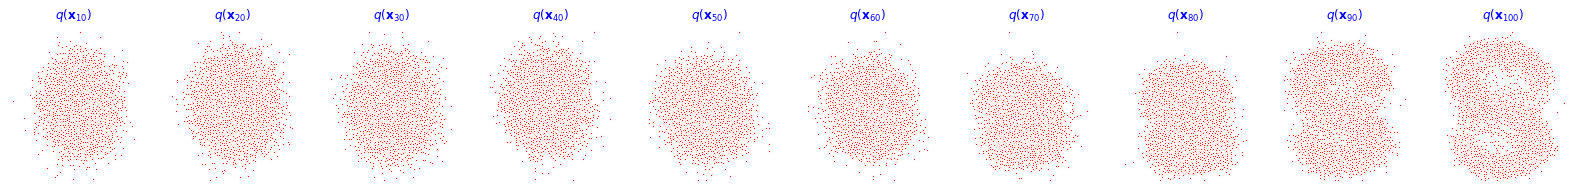

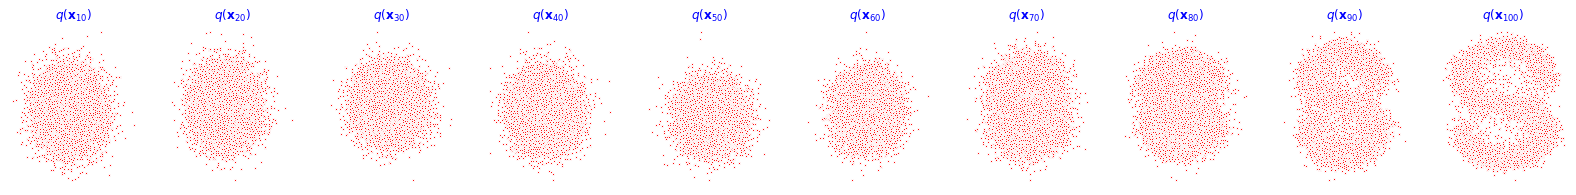

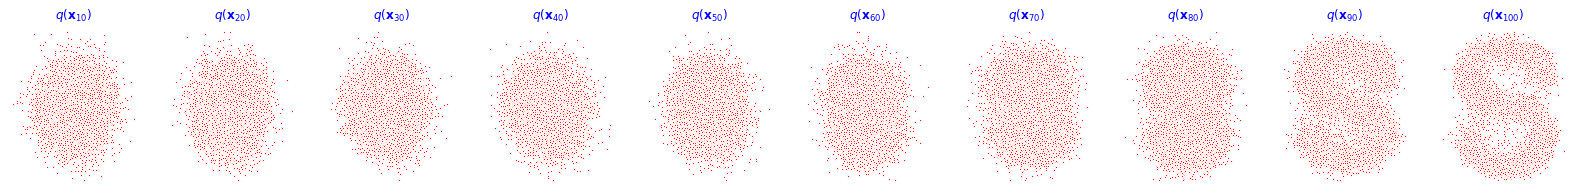

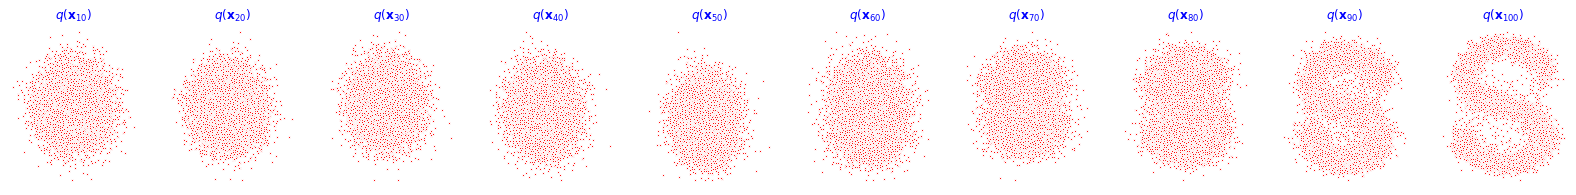

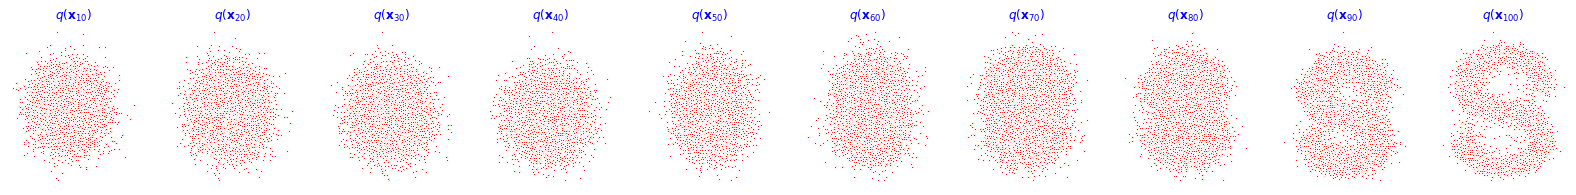

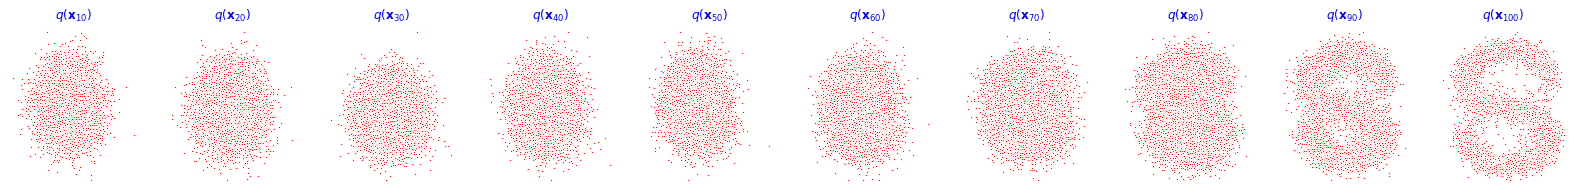

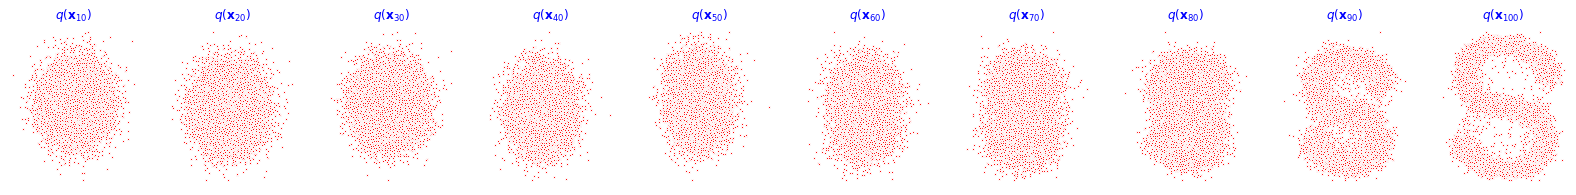

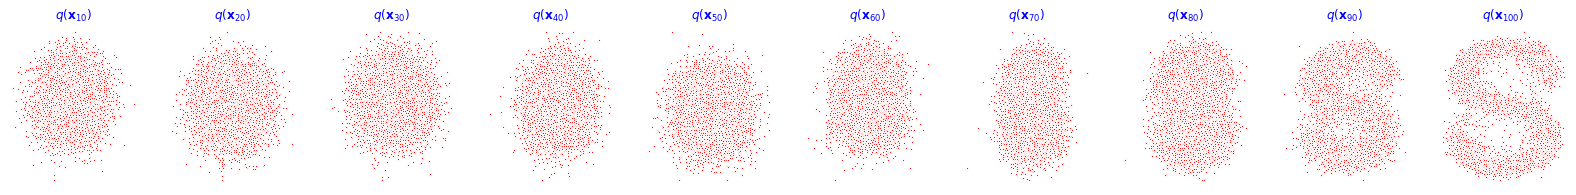

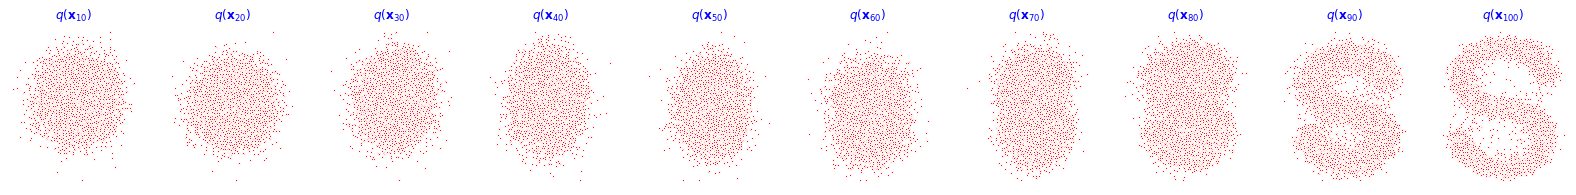

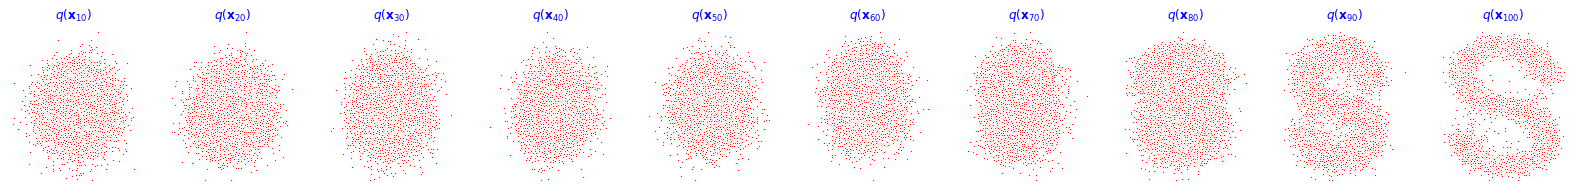

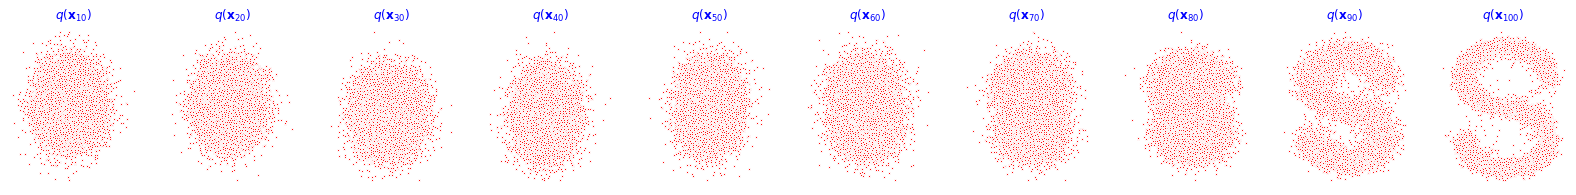

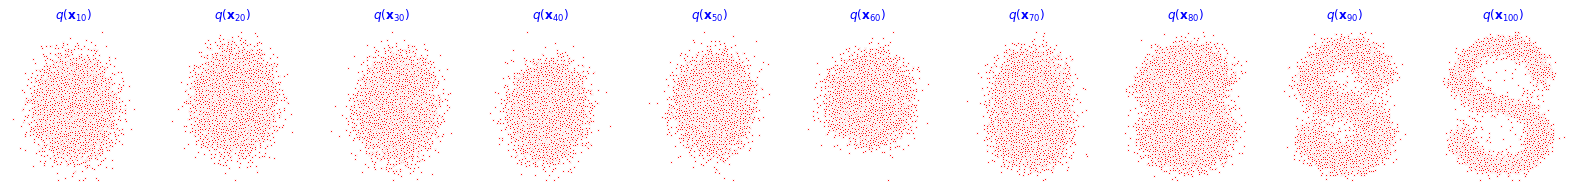

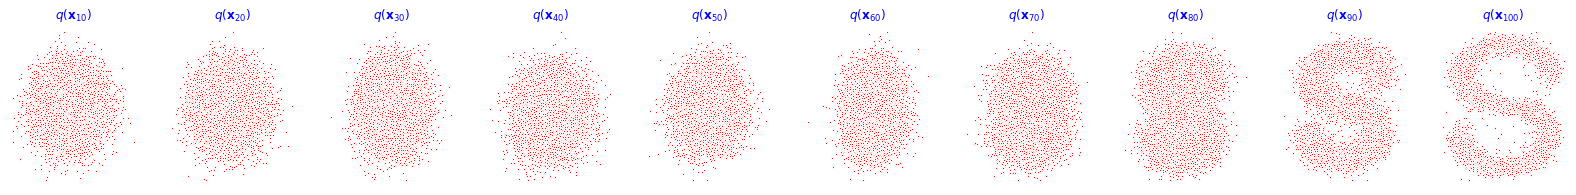

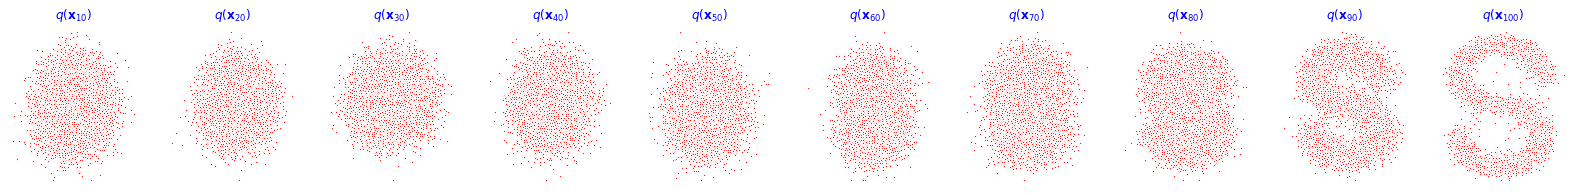

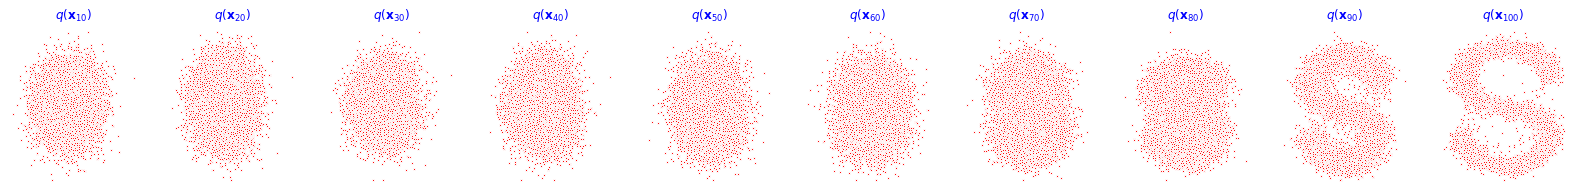

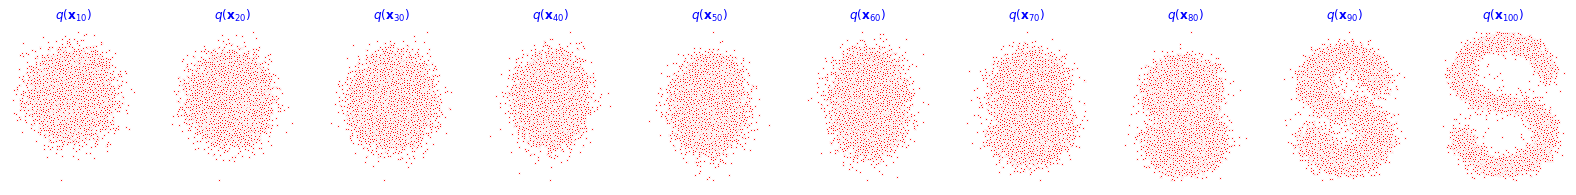

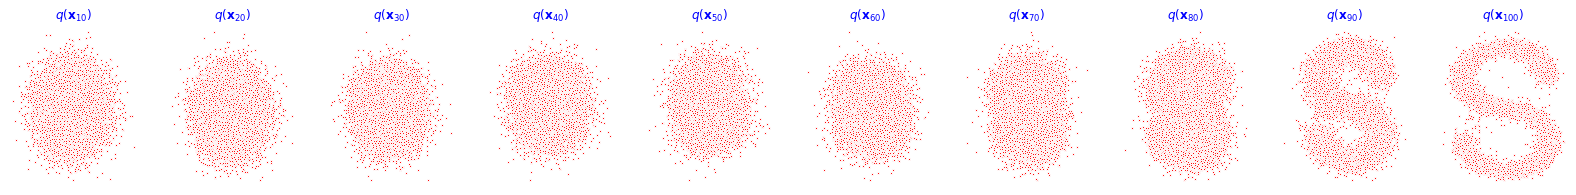

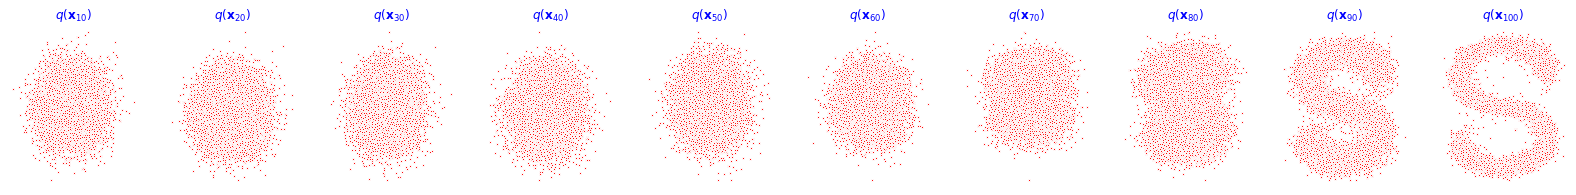

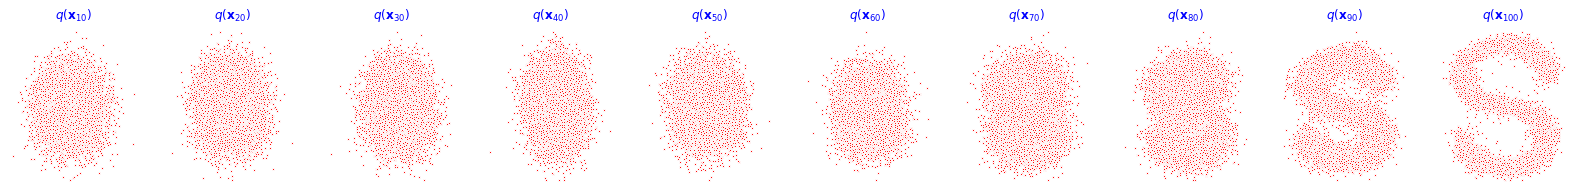

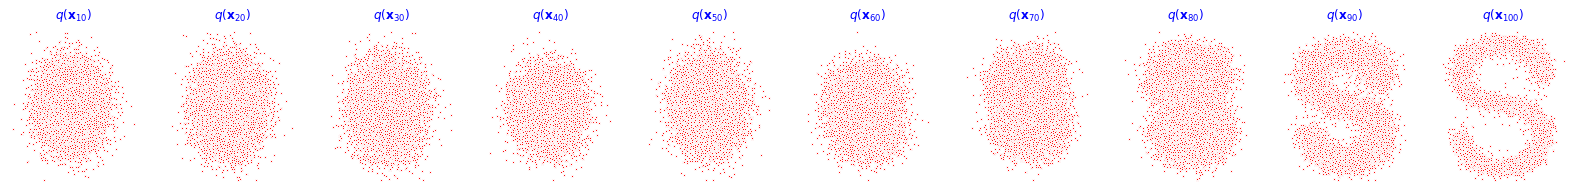

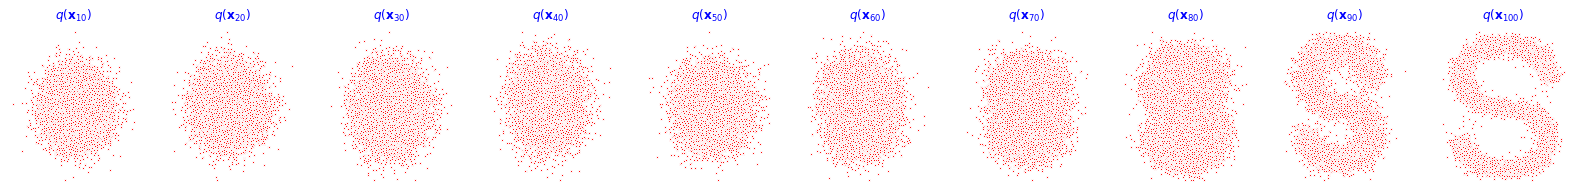

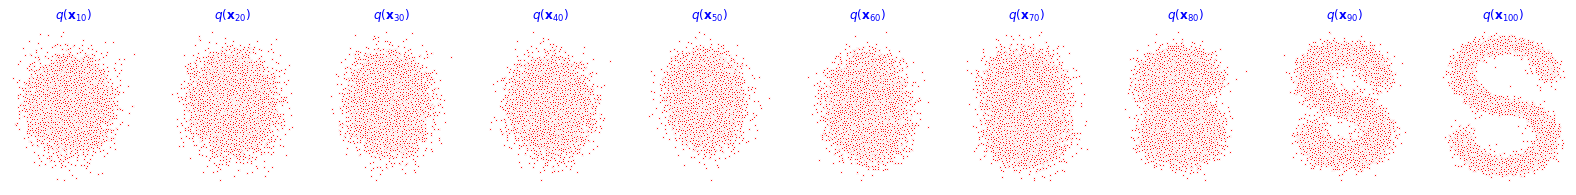

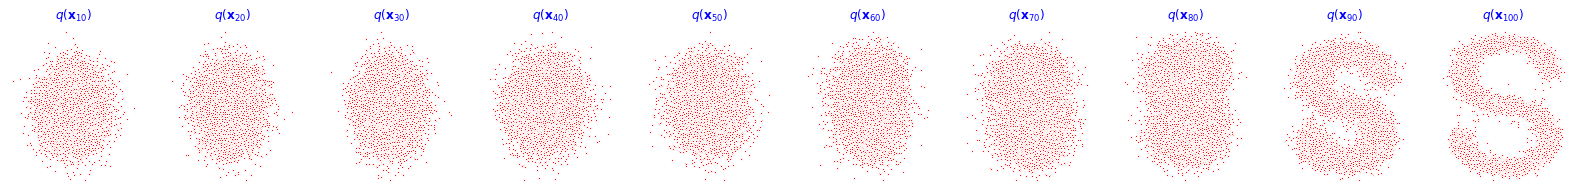

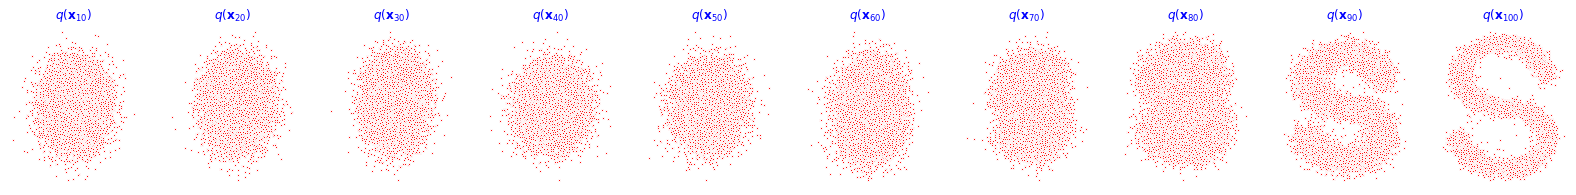

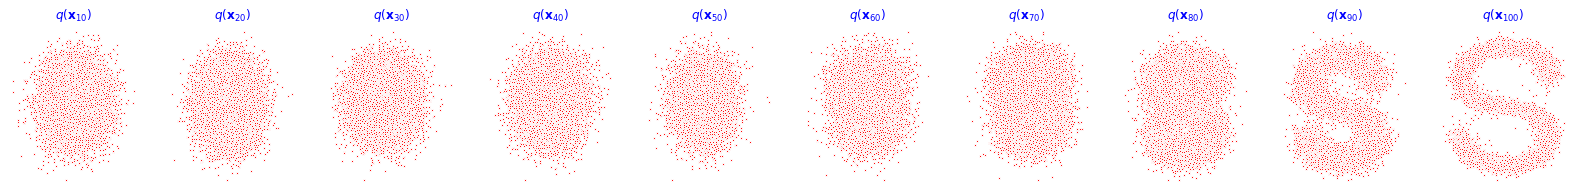

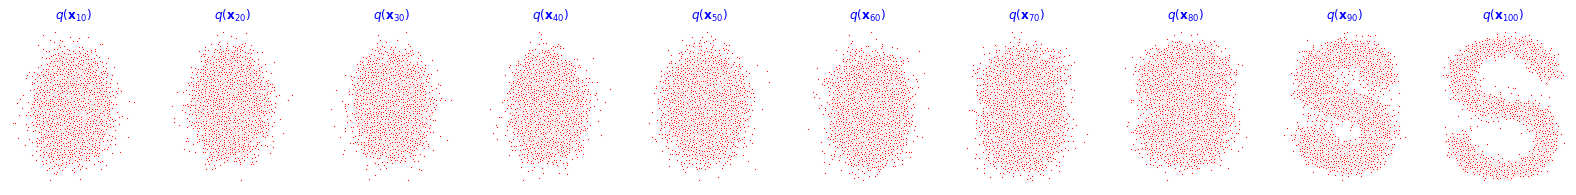

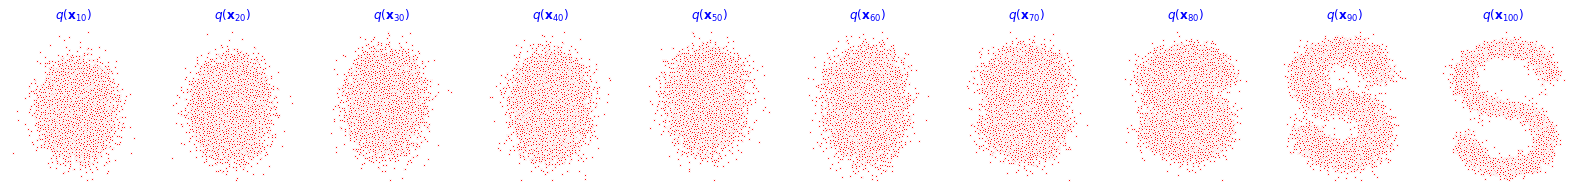

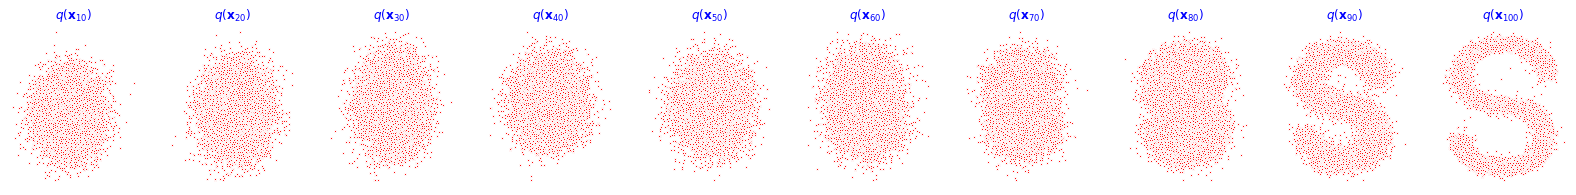

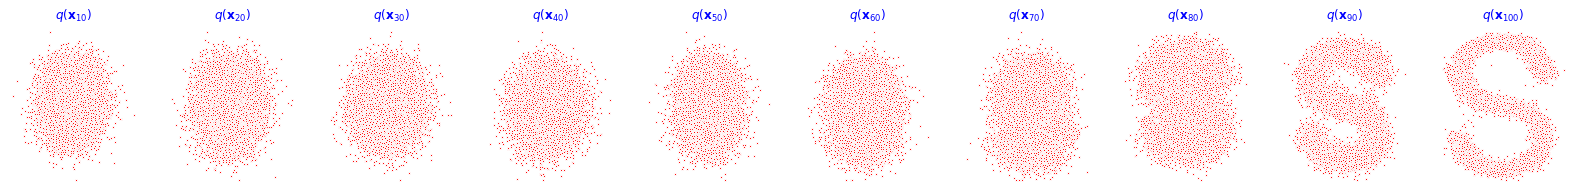

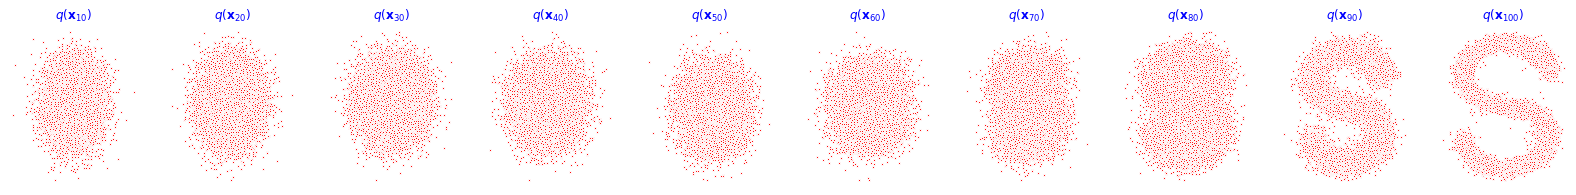

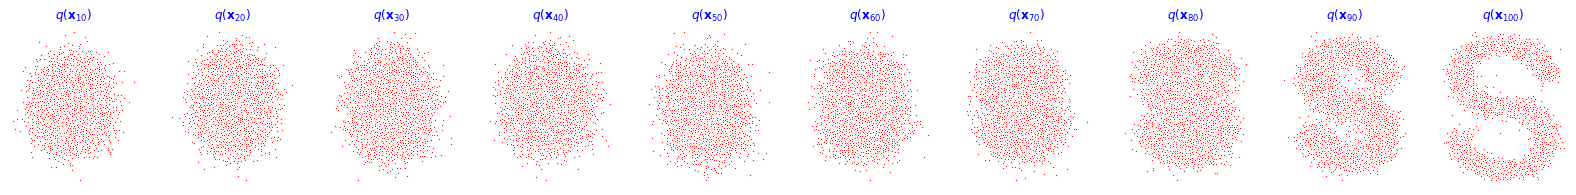

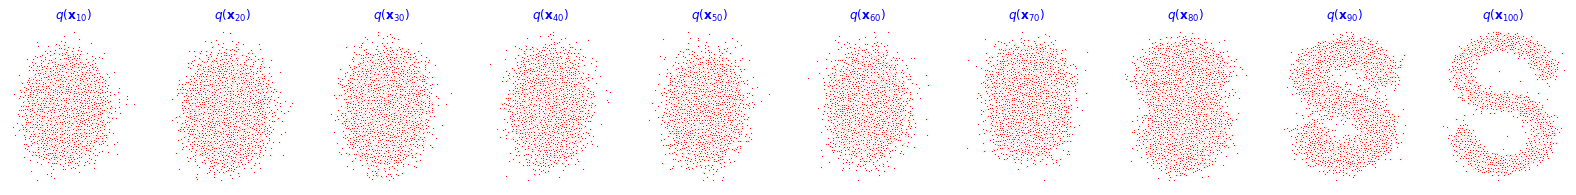

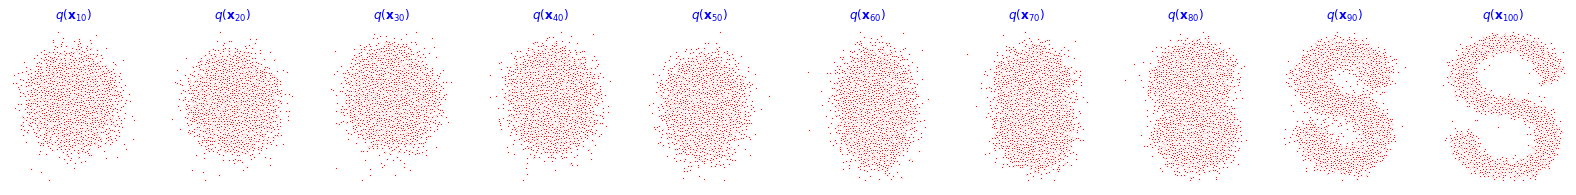

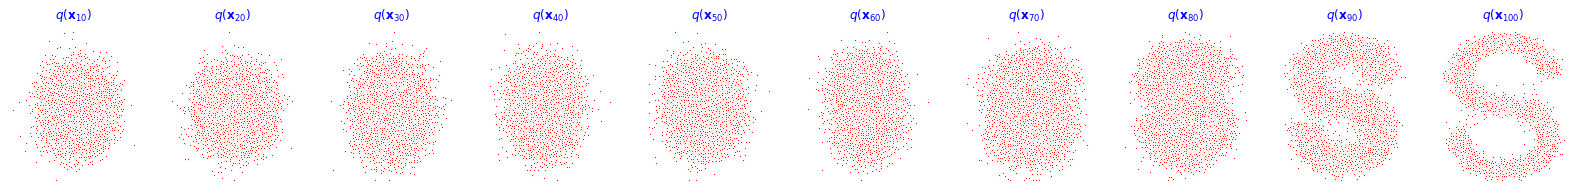

In [41]:
import torch.optim as optim

seed = 1234
num_epoch = 4000
batch_size = 128

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
model = MLPDiffusion(num_steps)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

print("__________开始训练____________")
for t in range(num_epoch):
    for idx, batch_x in enumerate(dataloader):
        # 训练
        loss = diffusion_loss_fn(model, batch_x,alphas_bar_sqrt,one_minus_alphas_bar_sqrt,num_steps)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
        optimizer.step()

 
    if (t % 100 == 0):
        # 推理
        print("epoch:",t,"     loss:",loss)
        x_seq = p_sample_loop(model, dataset.shape,num_steps,alphas,betas,one_minus_alphas_bar_sqrt)
        fig, axs = plt.subplots(1, 10, figsize=(28, 3))
        for i in range(1, 11):
            cur_x = x_seq[i * 10].detach()
            axs[i-1].scatter(cur_x[:, 0], cur_x[:, 1],color='red',edgecolor='white', s=5);
            axs[i-1].set_axis_off(); 
            axs[i-1].set_title('$q(\mathbf{x}_{'+str(i*10)+'})$', color='blue')
            